<a href="https://colab.research.google.com/github/Baronvera/MetagenomicaColab/blob/main/Phylogenetic_Zika_2024.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Análisis filogenético de los genomas del virus Zika (ZIKV)**

En este guia realizaremos un análisis filogenético a partir de secuencias genómicas del virus Zika (ZIKV). Para este proposito usaremos **Nextstrain**, el cual se compone dos partes fundamentales: **Augur** y **Auspice**. **Augur** es una serie de herramientas bioinformáticas componibles y modulares. Los usamos para crear *pipelines* para diferentes patógenos y diferentes análisis, que se pueden reproducir con los mismos datos de entrada y replicar cuando haya nuevos datos disponibles. **Auspice** es un programa de visualización basado en la web, para presentar e interactuar con datos filogenómicos y filogeográficos. **Auspice** es lo que ve cuando, por ejemplo, visita [nextstrain.org/mumps/na](nextstrain.org/mumps/na).

<figure>
<center>
<img src='https://drive.google.com/uc?export=download&id=1wsc50XoI3G1KdJvPoNALkZzQA1VU4pHz' width="30%" />
</center>
</figure>

El *pipeline* de Nextstrain generalmente requieren los siguientes pasos:

- Preparar secuencias y metadatos de patógenos

- Alinear secuencias

- Construir una filogenia a partir de secuencias alineadas

- Anotar la filogenia con fechas, secuencias y rasgos de patógenos ancestrales inferidos

- Exportar la filogenia anotada y los metadatos correspondientes a un formato legible por **auspice**

<figure>
<center>
<img src='https://drive.google.com/uc?export=download&id=1BAj5ubYkjCqPkkY38aVTNBDcxb3NdS1l' width="90%" />
</center>
</figure>



## **1. Instalación de recursos**

### **1.1. Instalacción conda**

In [ ]:
!pip install -q condacolab
import condacolab
condacolab.install()

In [ ]:
!conda --help

### **1.2. Instalacción de programas**

In [ ]:
!conda install -c conda-forge -c bioconda augur -y

In [ ]:
!conda install -c conda-forge -c bioconda auspice -y

In [ ]:
!pip install nextstrain-cli

In [ ]:
!conda install -c conda-forge -c bioconda nextalign -y

In [ ]:
!pip install snakemake

In [ ]:
!pip install awscli

In [ ]:
!conda install -c conda-forge -c bioconda git -y

## **2. Descargar datos**

Para fines de esta práctica podemos descargar directamente los archivos de ejemplo del tutorial de Zika de **nextstrain**. Estos consisten de un archivo fasta con las secuencias que analizaremos y un archivo con los metadatos.

Descargue la compilación del patógeno ZIKV que incluye datos de ejemplo y un `script` de compilación del patógeno. Para esto usaremos el comando `pip clone` para descargar el contenidi del github.

In [1]:
!git clone https://github.com/nextstrain/zika-tutorial

Cloning into 'zika-tutorial'...
remote: Enumerating objects: 107, done.
remote: Counting objects: 100% (50/50), done.
remote: Compressing objects: 100% (28/28), done.
remote: Total 107 (delta 26), reused 28 (delta 19), pack-reused 57 (from 1)
Receiving objects: 100% (107/107), 101.20 KiB | 2.41 MiB/s, done.
Resolving deltas: 100% (45/45), done.


Entramos al directorio que descargamos. Cuando haya terminado, usted estará en un directorio llamado /content/zika-tutorial/

In [ ]:
cd zika-tutorial/

## **3. Preparar las secuencias**
Una compilación de Nextstrain generalmente comienza con una colección de secuencias de patógenos en un solo archivo FASTA y con una tabla correspondiente de metadatos que describen las secuencias en un archivo de texto delimitado por tabulaciones. Para este tutorial, usaremos un conjunto de datos de ejemplo con un subconjunto de 34 virus.

Cada registro de secuencia contiene el ID de la cepa del virus (el nombre de la secuencia) en la línea del encabezado seguido de la secuencia del virus.

<figure>
<center>
<img src='https://drive.google.com/uc?export=download&id=1QNxm4If0dhV8iU6fpobOLEI-SLt3VaqF' width="70%" />
</center>
</figure>

El ID de cada registro de secuencia se vincula al archivo de metadatos delimitado por tabulaciones por el campo de cepa de este último. El archivo de metadatos contiene un encabezado de nombres de las columnas seguido la información para cada secuencia. Un archivo de metadatos de ejemplo tiene el siguiente aspecto.

<figure>
<center>
<img src='https://drive.google.com/uc?export=download&id=1s8Q0E5UVb6iW2HXBiOEYd8iKvUlRHWg9' width="90%" />
</center>
</figure>

## **4. Indexar las secuencias**

En este paso calculamos la composición de las secuencias (p. Ej., Número de nucleótidos, espacios, caracteres no válidos y longitud total de la secuencia) antes del filtrado. El índice de secuencia resultante acelera los pasos de filtrado posteriores, especialmente en flujos de trabajo más complejos.

In [ ]:
!mkdir -p results/

In [ ]:
!augur index \
  --sequences data/sequences.fasta \
  --output results/sequence_index.tsv

Las primeras líneas del índice de secuencia se ven así.



<figure>
<center>
<img src='https://drive.google.com/uc?export=download&id=19yfGFY5JmOAmJMWPzzMYi57Fg3LAE_3v' width="90%" />
</center>
</figure>



## **5. Filtrar las secuencias**

Filtre las secuencias analizadas y los metadatos para excluir cepas del análisis posterior y submuestrear las cepas restantes a un número fijo de muestras por grupo.

In [ ]:
!augur filter \
  --sequences data/sequences.fasta \
  --sequence-index results/sequence_index.tsv \
  --metadata data/metadata.tsv \
  --exclude config/dropped_strains.txt \
  --output results/filtered.fasta \
  --group-by country year month \
  --sequences-per-group 20 \
  --min-date 2012

## **6. Alinear las secuencias**

Cree una alineación de varias secuencias utilizando una referencia. Después de esta alineación, se eliminan las columnas con espacios en la referencia. Además, la marca **--fill-gaps** llena los espacios en las secuencias que no son de referencia con caracteres "N". Estas modificaciones fuerzan a todas las secuencias al mismo espacio de coordenadas que la secuencia de referencia.

In [ ]:
!augur align \
  --sequences results/filtered.fasta \
  --reference-sequence config/zika_outgroup.gb \
  --output results/aligned.fasta \
  --fill-gaps

Ahora las secuencias de patógenos están listas para su análisis.

## **7. Construir la filogenia**


Deduzca un árbol filogenético a partir de la alineación de múltiples secuencias.

In [ ]:
!augur tree \
  --alignment results/aligned.fasta \
  --output results/tree_raw.nwk

El árbol resultante se almacena en formato *Newick*. Las longitudes de las ramas en este árbol miden la divergencia de nucleótidos.

## **8. Obtenga un árbol resuelto en el tiempo**

**Augur** también puede ajustar la longitud de las ramas en este árbol para posicionar las puntas por su fecha de muestra e inferir el momento más probable de sus antepasados, utilizando **TreeTime**. Ejecute el comando **refine** para aplicar **TreeTime** al árbol filogenético original y producir un "árbol de tiempo".

In [ ]:
!augur refine \
  --tree results/tree_raw.nwk \
  --alignment results/aligned.fasta \
  --metadata data/metadata.tsv \
  --output-tree results/tree.nwk \
  --output-node-data results/branch_lengths.json \
  --timetree \
  --coalescent opt \
  --date-confidence \
  --date-inference marginal \
  --clock-filter-iqd 4

Además de asignar tiempos a los nodos internos, el comando `refine` filtra las sugerencias que probablemente sean valores atípicos y asigna intervalos de confianza a las fechas inferidas. Las longitudes de las ramas en el árbol de Newick resultante miden la divergencia de nucleótidos ajustada. Todos los demás datos inferidos por **TreeTime** se almacenan por cepa o nombre de nodo interno en el archivo JSON correspondiente.

## **9. Anotar la filogenia**

### **9.1. Reconstruir rasgos ancestrales**

**TreeTime** también puede inferir rasgos ancestrales de un árbol filogenético existente y los metadatos que anotan cada punta del árbol. El siguiente comando infiere la región y el país de todos los nodos internos del árbol de tiempo y los metadatos originales. Al igual que con el comando **refine**, la salida JSON resultante se indexa por secuencia o nombre de nodo interno.

In [ ]:
!augur traits \
  --tree results/tree.nwk \
  --metadata data/metadata.tsv \
  --output-node-data results/traits.json \
  --columns region country \
  --confidence

### **9.2. Inferir secuencias ancestrales**

A continuación, infiera la secuencia ancestral de cada nodo interno e identifique cualquier mutación de nucleótidos en las ramas que conducen a cualquier nodo del árbol.

In [ ]:
!augur ancestral \
  --tree results/tree.nwk \
  --alignment results/aligned.fasta \
  --output-node-data results/nt_muts.json \
  --inference joint

### **9.3. Identificar mutaciones de aminoácidos**

Identificar mutaciones de aminoácidos a partir de mutaciones de nucleótidos y una secuencia de referencia con anotaciones de coordenadas de genes. El archivo JSON resultante contiene mutaciones de aminoácidos indexadas por cepa o nombre de nodo interno y por nombre de gen. Para exportar un archivo FASTA con las traducciones completas de aminoácidos para cada gen de la secuencia de cada nodo, especifique el parámetro --alignment-output en la forma de results/align_aa_%GENE.fasta.

In [ ]:
!augur translate \
  --tree results/tree.nwk \
  --ancestral-sequences results/nt_muts.json \
  --reference-sequence config/zika_outgroup.gb \
  --output-node-data results/aa_muts.json

## **10. Exportar los resultados**

Finalmente, recopile todas las anotaciones de nodo y metadatos y expórtelos en formato JSON de **Auspice**. Esto se refiere a tres archivos de configuración para definir colores a través de config/colors.tsv, coordenadas de latitud y longitud a través de config/lat_longs.tsv, así como al título de la página, mantenedor, filtros presentes, etc., a través de config/auspice_config.json. El árbol resultante y los archivos JSON de metadatos son las entradas a la herramienta de visualización Auspice.

In [ ]:
!augur export v2 \
  --tree results/tree.nwk \
  --metadata data/metadata.tsv \
  --node-data results/branch_lengths.json \
              results/traits.json \
              results/nt_muts.json \
              results/aa_muts.json \
  --colors config/colors.tsv \
  --lat-longs config/lat_longs.tsv \
  --auspice-config config/auspice_config.json \
  --output auspice/zika.json

## **11. Visualiza los resultados**

Utilice **auspice** para visualizar los resultados. Para facilitar ver el archivo vamos a detener el proceso dando en el botón de **Stop**

In [ ]:
!auspice view --datasetDir auspice

Descargue el archivo **zika.json** que se encuentra dentro del directorio de /content/zika-tutorial/auspice/. Luego vamos al sitio web https://auspice.us/ y arrastre este archivo.

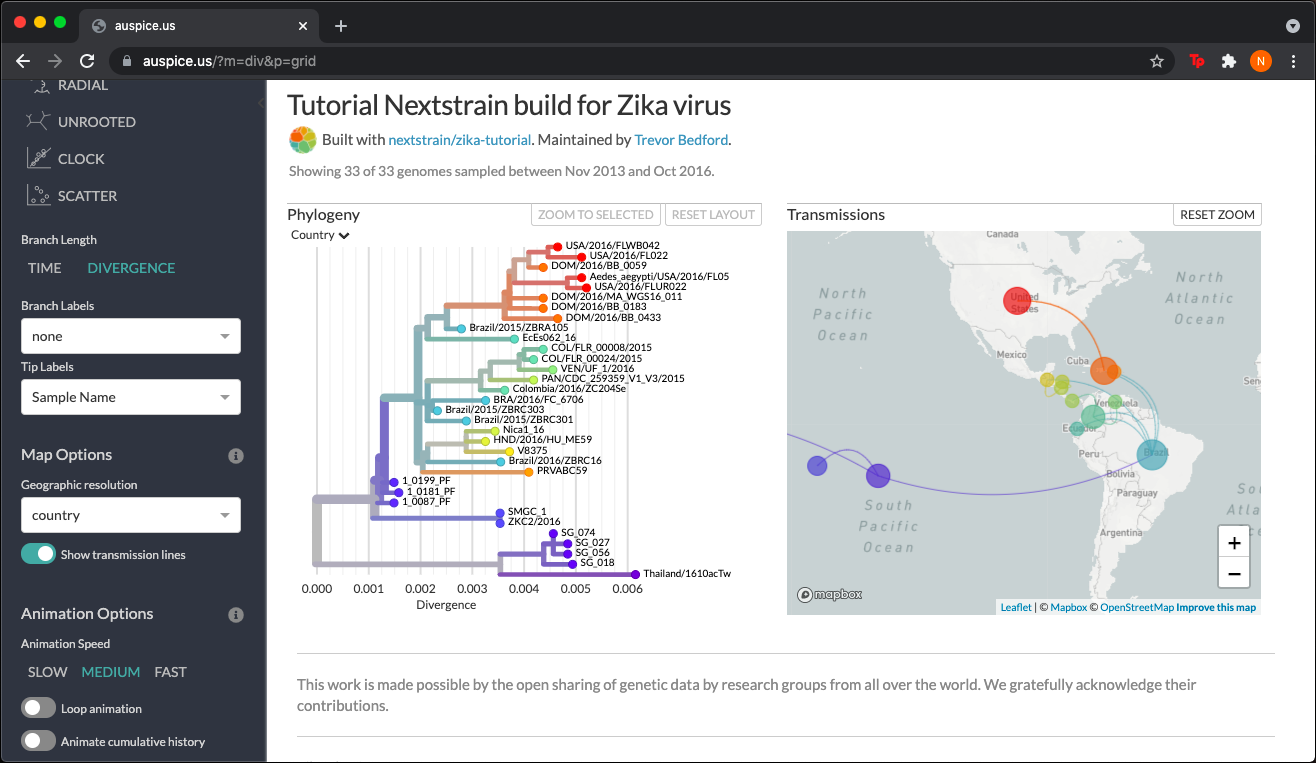

## **12. Microreact**

También podemos ver nuestros resultados mediante la plataforma web **microreact** (https://microreact.org/upload).

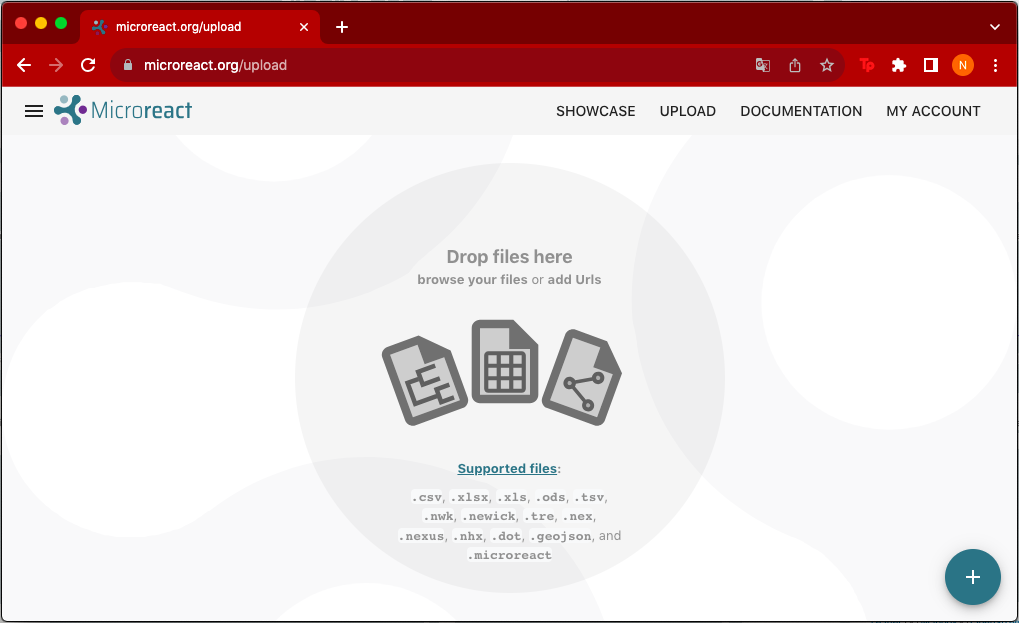

Podemos cargar los datos simplemente arrastrando los archivos sobre cada campo. Para esto requerimos nuestro árbol ["tree.nwk"](https://drive.google.com/uc?export=download&id=1G_9J0ou1J3IUpowAJxYXJdYsuEMLpB2s) y un metadato formateado para esta plataforma ([metadata.tsv](https://drive.google.com/uc?export=download&id=1PgTeselwJ_rgTeDC8iJCyLtrMf7QGfzI)). Para habilitar las opciones de mapa de `microreact` deberá modificar el metadato para usar la codificación para países de ISO3166-1/2. Usted puede usar la herramienta web [www.tracemyip.org](https://www.tracemyip.org/tools/country-code-list-alpha-2-alhpa-3-converter/). Siemplemente pegue la lista de nombres de los paises en la ventana superior deshabilite la opción "remove duplicates" y presione en "Convert Country List". En la ventana inferior aparecerá la lista de países con la codificación reuquerida, ahora peguela en el metadato.

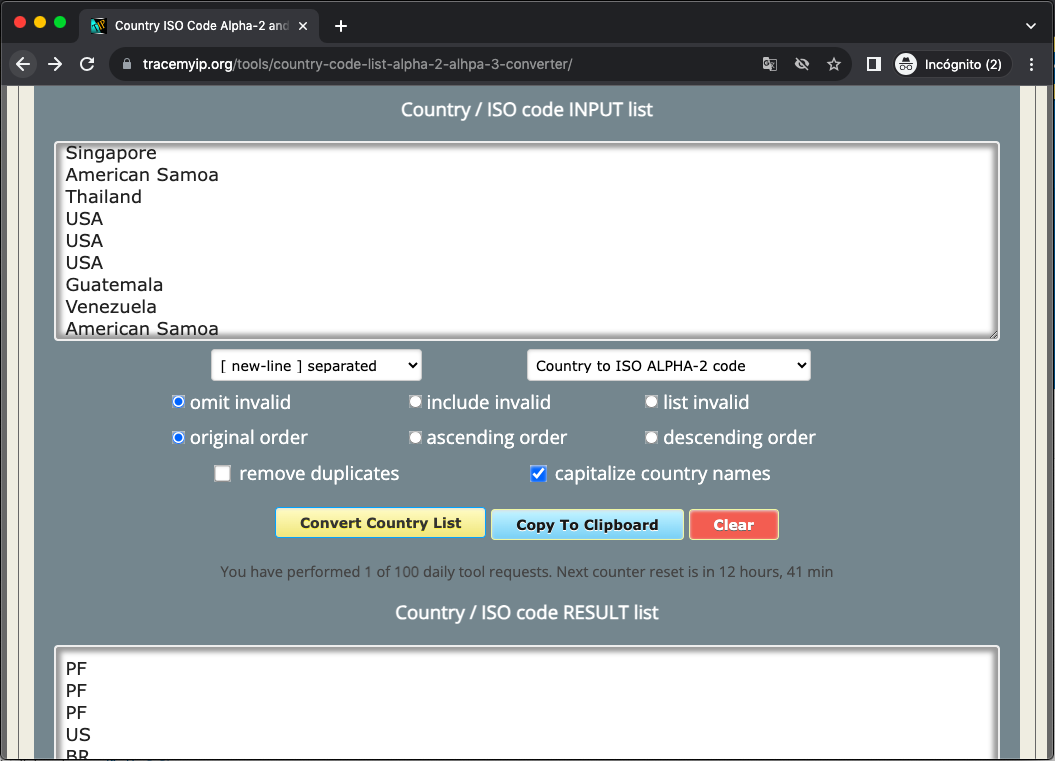

Ahora importe sus archivos a `Microreact" y de en "CONTINUE".

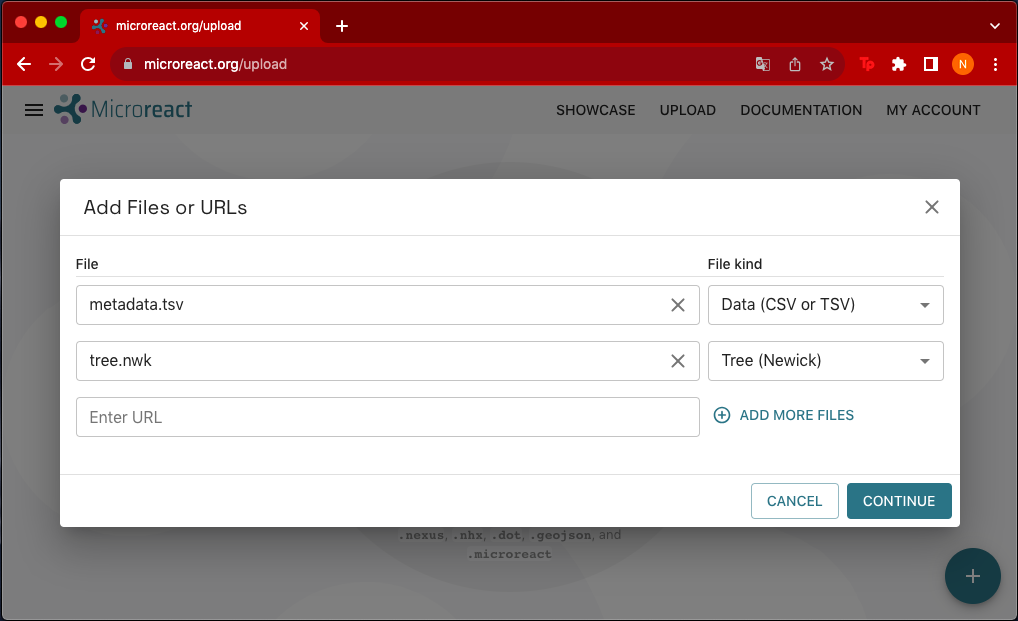

Una vez cargados podremos ver y explorar nuestros resultados.

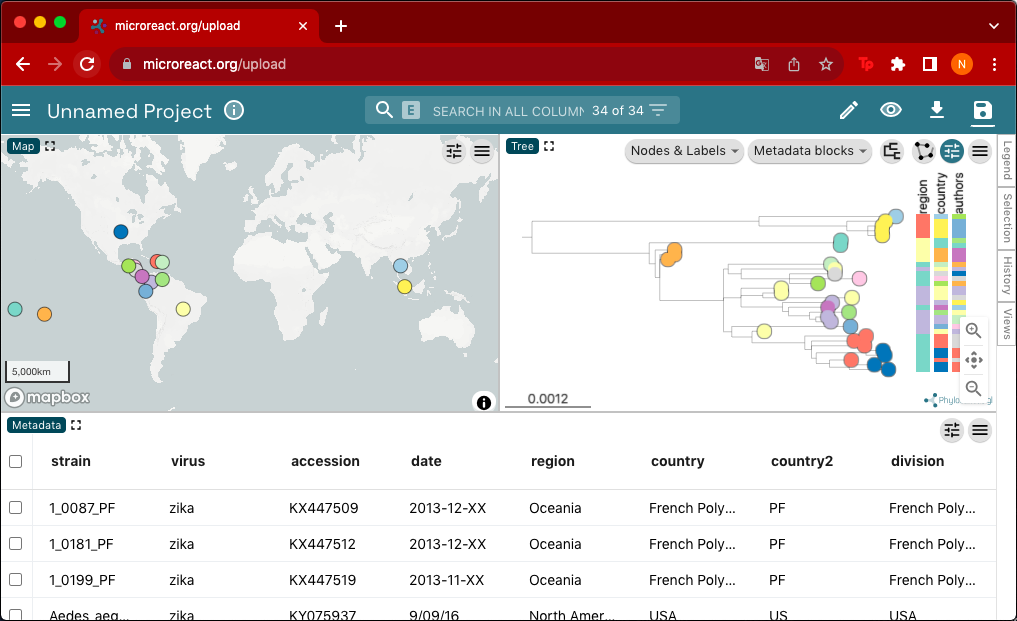